In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
#New Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

RANDOM_SEED = 42

In [24]:
dataset = 'model/keypoint_classifier/dataset.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier1.keras'

In [25]:
NUM_CLASSES = 7

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [29]:
print(X_train.shape)

(787, 42)


In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [17]:
#New data
num_samples = X_train.shape[0] // sequence_length
X_train = X_train[:num_samples * sequence_length]  # Ensure it's divisible by sequence_length
X_train = np.reshape(X_train, (num_samples, sequence_length, num_features))

In [18]:
# New model

sequence_length = 30  # For example, 30 frames per gesture
num_features = 42  # Example: 21 landmarks * 2 (x, y)

# Define the model
model = Sequential([
    GRU(128, input_shape=(sequence_length, num_features), return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

In [31]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)                  │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │             860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │              77 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,147 (4.48 KB)

 Trainable params: 1,147 (4.48 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:

'''cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)'''

In [33]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    'model/keypoint_classifier/keypoint_classifier1.keras',  # Change the extension to .keras
    verbose=1,
    save_weights_only=False
)

# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)


In [22]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 26
'y' sizes: 787


In [14]:

val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9267 - loss: 0.3188  


In [15]:

model = tf.keras.models.load_model(model_save_path)

In [16]:

predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
[1.7588129e-04 1.2537341e-01 6.7782426e-01 1.3085459e-01 1.3998668e-02
 4.6048872e-03 4.7168288e-02]
2


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


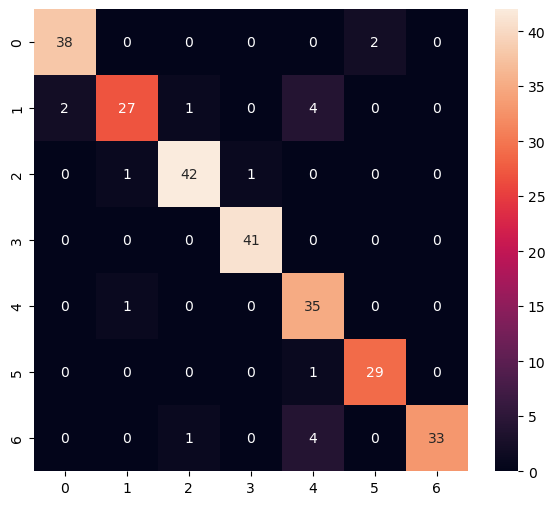

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.93      0.79      0.86        34
           2       0.95      0.95      0.95        44
           3       0.98      1.00      0.99        41
           4       0.80      0.97      0.88        36
           5       0.94      0.97      0.95        30
           6       1.00      0.87      0.93        38

    accuracy                           0.93       263
   macro avg       0.93      0.93      0.93       263
weighted avg       0.94      0.93      0.93       263



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite

In [18]:
model.save(model_save_path, include_optimizer=False)

In [ ]:
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier1.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmpph369hlc\assets


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmpph369hlc\assets


In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 997 μs


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.8854864e-01 1.0580237e-02 8.7004591e-04 1.2242134e-07 9.1468081e-07]
0
